<a href="https://colab.research.google.com/github/subhashpolisetti/Clustering-Techniques-and-Embeddings/blob/main/6_Clustering_Time_Series_Using_Deep_Features_and_tslearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Clustering with tslearn and ResNet50 Features

## Overview:
This notebook demonstrates how to cluster time series data using `tslearn`, a machine learning library designed specifically for time-series data, and how to use a pre-trained ResNet50 model for feature extraction. The time-series data is generated synthetically to simulate different patterns such as sine waves, linear trends, and step functions. The notebook performs clustering using two different methods and compares the results based on their silhouette scores.

## Key Steps:

1. **Data Generation:**
   - We generate synthetic time series data consisting of 100 samples, each of length 50.
   - The data is divided into three distinct patterns:
     - **Pattern 1**: Sine wave with added noise.
     - **Pattern 2**: Linear trend with added noise.
     - **Pattern 3**: Step function with added noise.

2. **Visualization of Time Series Data:**
   - The generated time series patterns are visualized to provide an example of the different shapes of the time series.

3. **Clustering with tslearn:**
   - The synthetic data is transformed into a format suitable for `tslearn` clustering.
   - The data is scaled using `TimeSeriesScalerMeanVariance` to standardize the time series.
   - The `TimeSeriesKMeans` clustering algorithm is applied to group the time series into three clusters based on Dynamic Time Warping (DTW) as the distance metric.
   - The silhouette score is calculated to evaluate the clustering quality.

4. **Feature Extraction with ResNet50:**
   - The synthetic time series data is normalized and reshaped into 2D images to be fed into a pre-trained ResNet50 model.
   - The model is used to extract features from the time series, which are then clustered using `KMeans`.

5. **Clustering with KMeans on ResNet Features:**
   - After feature extraction with ResNet50, `KMeans` clustering is applied to the features.
   - The silhouette score is calculated to evaluate the clustering performance.

6. **Comparison of Clustering Results:**
   - The clustering results from `tslearn` and `ResNet + KMeans` are compared.
   - A plot is generated to visualize the cluster centers obtained from both clustering methods.
   - The silhouette scores for both clustering methods are compared to assess which method performed better.

## Results:
- The silhouette scores for both clustering methods are printed, giving an indication of the quality of the clustering.
- Visualizations are provided to compare how well each method has clustered the time series data.

## Libraries Used:
- `tslearn`: For time-series clustering using Dynamic Time Warping (DTW).
- `tensorflow`: For extracting features using the pre-trained ResNet50 model.
- `sklearn`: For clustering with `KMeans` and calculating the silhouette score.

## Prerequisites:
- `tslearn`, `dtaidistance`, and `tensorflow` must be installed before running this notebook.


In [1]:
# Install required packages first
!pip install tslearn dtaidistance tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.6 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import sequence
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

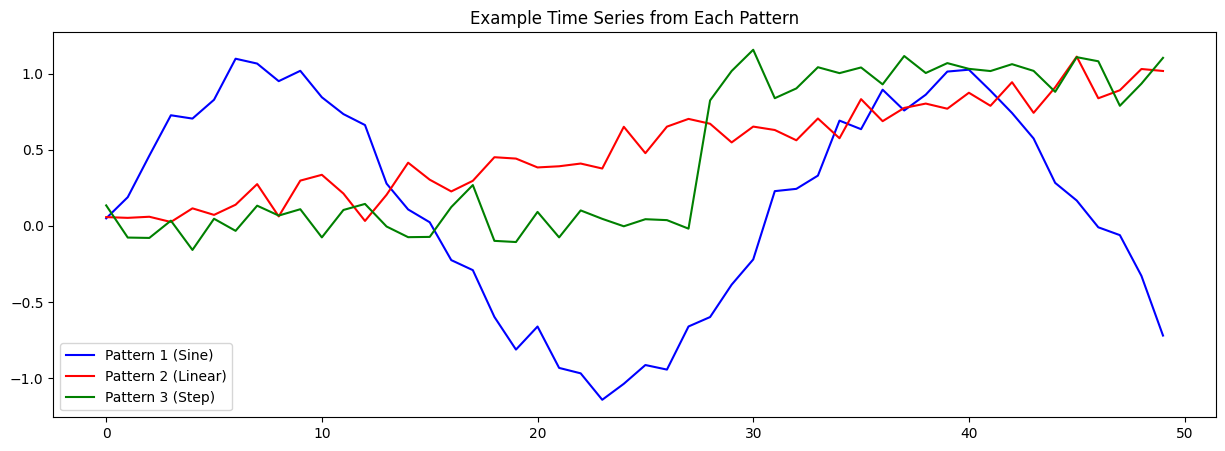

In [3]:
# Set a random seed for reproducibility of results
np.random.seed(42)

# Define the number of time series and the length of each series
n_series = 100  # number of time series
length = 50     # length of each series

# Generate different patterns for the time series data

# Pattern 1: Sine wave with noise
# Generate 'n_series//3' sine wave series with random noise
t = np.linspace(0, 10, length)  # Time values from 0 to 10, evenly spaced
pattern1 = [np.sin(t) + np.random.normal(0, 0.1, length) for _ in range(n_series//3)]  # Adding noise to sine wave

# Pattern 2: Linear trend with noise
# Generate 'n_series//3' linearly increasing series with random noise
pattern2 = [np.linspace(0, 1, length) + np.random.normal(0, 0.1, length)
           for _ in range(n_series//3)]  # Adding noise to a linearly increasing series

# Pattern 3: Step function with noise
# Generate 'n_series//3' step function series with random noise
pattern3 = []
for _ in range(n_series//3):
    series = np.zeros(length)  # Start with a zero array for each series
    change_point = np.random.randint(10, length-10)  # Randomly select a change point
    series[change_point:] = 1  # Set values to 1 after the change point, creating a step
    series += np.random.normal(0, 0.1, length)  # Add random noise to the step function
    pattern3.append(series)  # Append the series to the list

# Combine all the generated patterns into one dataset
data = pattern1 + pattern2 + pattern3
data = np.array(data)  # Convert the list of series into a numpy array

# Create labels for validation (3 classes: 0, 1, and 2 corresponding to the 3 patterns)
true_labels = np.repeat([0, 1, 2], n_series//3)

# Plot some example series from each pattern to visualize them
plt.figure(figsize=(15, 5))  # Set figure size for plotting
plt.plot(data[0], 'b-', label='Pattern 1 (Sine)')  # Plot first example as blue (Sine pattern)
plt.plot(data[n_series//3], 'r-', label='Pattern 2 (Linear)')  # Plot an example of linear trend in red
plt.plot(data[2*n_series//3], 'g-', label='Pattern 3 (Step)')  # Plot an example of step function in green
plt.title('Example Time Series from Each Pattern')  # Title for the plot
plt.legend()  # Display legend for the different patterns
plt.show()  # Show the plot


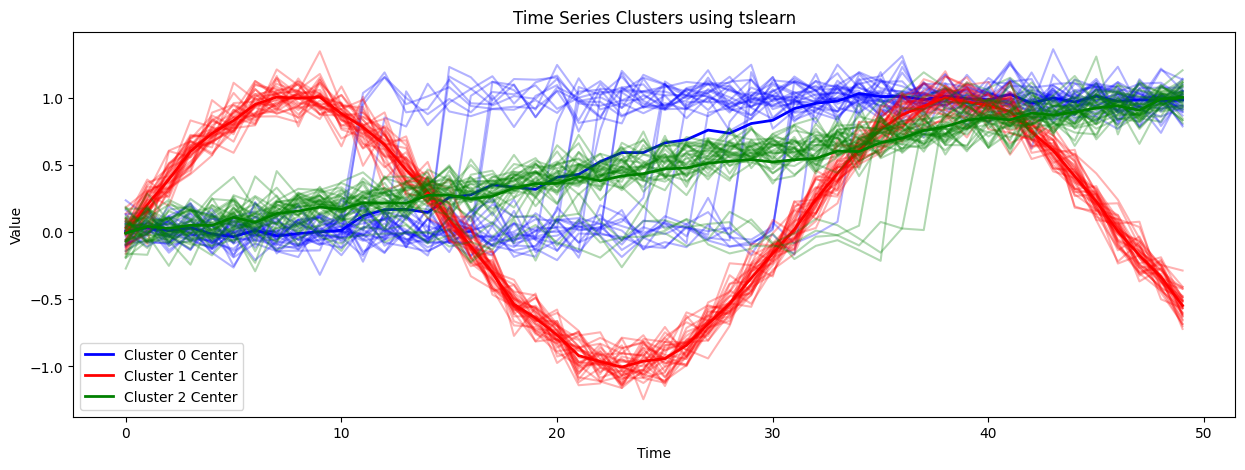

tslearn Clustering Silhouette Score: 0.618


In [4]:
# tslearn clustering
# Convert the raw time series data to tslearn format
data_ts = to_time_series_dataset(data)

# Scale the time series data using mean-variance normalization
ts_scaler = TimeSeriesScalerMeanVariance()  # This scaler standardizes the data (mean = 0, variance = 1)
data_ts_scaled = ts_scaler.fit_transform(data_ts)  # Apply the scaling to the dataset

# Perform TimeSeriesKMeans clustering
n_clusters = 3  # Define the number of clusters to create
km_ts = TimeSeriesKMeans(n_clusters=n_clusters,  # Initialize KMeans clustering for time series data
                        metric="dtw",  # Use Dynamic Time Warping (DTW) as the distance metric
                        random_state=42)  # Set a random seed for reproducibility
tslearn_clusters = km_ts.fit_predict(data_ts_scaled)  # Perform clustering and predict cluster labels for each time series

# Visualize tslearn clustering results
plt.figure(figsize=(15, 5))  # Set figure size for plotting
colors = ['b', 'r', 'g']  # Define colors for each cluster

# Loop through each cluster to visualize its contents
for i in range(n_clusters):
    cluster_data = data[tslearn_clusters == i]  # Select the data that belongs to the current cluster

    # Plot individual series from the current cluster with some transparency
    for series in cluster_data:
        plt.plot(series, c=colors[i], alpha=0.3)  # Use alpha=0.3 for transparency in individual series

    # Plot the cluster center (mean of all series in the cluster)
    plt.plot(np.mean(cluster_data, axis=0),  # Calculate the mean of the series in the cluster
            c=colors[i],  # Use the cluster's color
            linewidth=2,  # Set line thickness for the cluster center
            label=f'Cluster {i} Center')  # Label for the cluster center

# Add title and axis labels to the plot
plt.title('Time Series Clusters using tslearn')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()  # Display the legend for cluster centers
plt.show()  # Show the plot

# Calculate and print the silhouette score for the clustering
# Silhouette score measures how similar each sample is to its own cluster compared to other clusters
tslearn_score = silhouette_score(data_ts, tslearn_clusters)
print(f"tslearn Clustering Silhouette Score: {tslearn_score:.3f}")  # Print the silhouette score


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


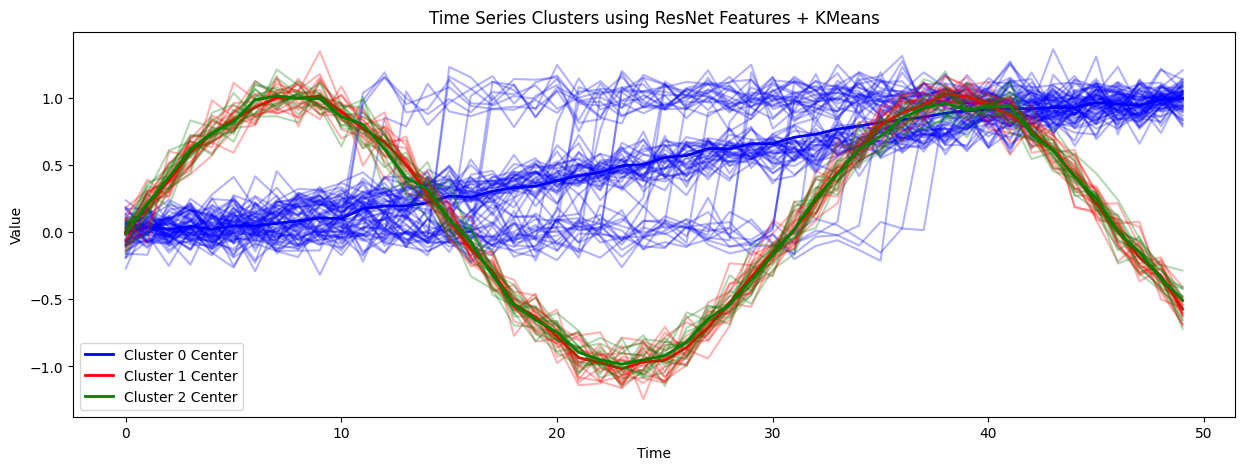

ResNet Clustering Silhouette Score: 0.487


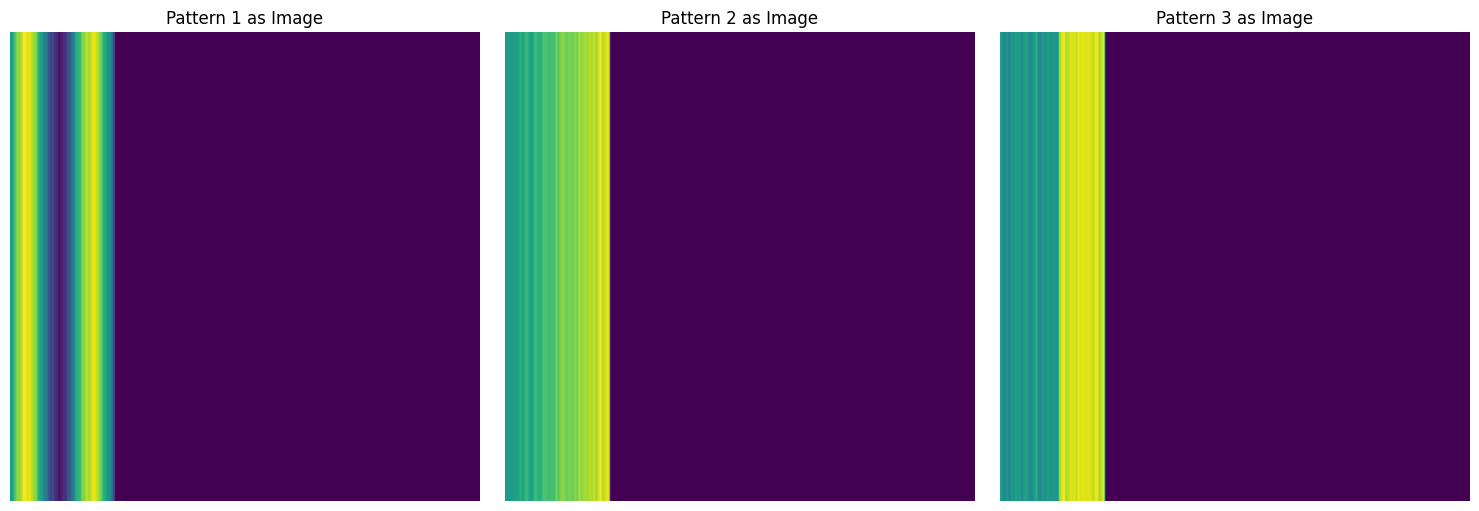

In [5]:
# Feature extraction using ResNet50

# Step 1: Normalize the data to [0,1] range
# This normalization step ensures that the data values are between 0 and 1, which is a common preprocessing step
# for neural networks to help them converge faster during training.
data_normalized = (data - data.min()) / (data.max() - data.min())

# Step 2: Create 2D images from the time series
# Reshape the data into a format suitable for input to the ResNet50 model (which expects images)
batch_size = data.shape[0]  # Get the number of time series (samples)
data_resized = np.zeros((batch_size, 224, 224, 3))  # Initialize an empty array to store the 2D images

# Loop over each time series to create 2D images
for i in range(batch_size):
    # Take each normalized time series
    series = data_normalized[i]

    # Create an empty 2D image of size 224x224
    img = np.zeros((224, 224))

    # For each "column" of the image, place the time series data, stretching it over the width (224 pixels)
    for j in range(224):
        img[j, :len(series)] = series  # Spread the series data into the 2D image

    # Add the channel dimension by stacking the same image three times to create an RGB image
    img = np.stack([img, img, img], axis=-1)  # RGB image, where each channel has the same data
    data_resized[i] = img  # Store the generated image in the data_resized array

# Step 3: Load the pretrained ResNet50 model and extract features
# ResNet50 is a deep convolutional neural network pretrained on ImageNet, which we use here to extract features
# from our time series data (converted to images).
model = ResNet50(include_top=False, pooling='avg')  # We exclude the final classification layer and apply average pooling
features = model.predict(data_resized, batch_size=32)  # Run the 2D images through the ResNet50 model to extract features

# Step 4: Perform KMeans clustering on the extracted features
# Now that we have feature vectors for each time series (converted to images), we perform KMeans clustering
# to group similar time series based on the extracted features.
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Initialize KMeans with the desired number of clusters
resnet_clusters = kmeans.fit_predict(features)  # Perform clustering and get the cluster assignments

# Step 5: Visualize the clustering results
# Plot the individual time series in each cluster and the cluster centers
plt.figure(figsize=(15, 5))  # Set figure size for the plot
colors = ['b', 'r', 'g']  # Assign colors to different clusters

# Loop through each cluster to visualize its contents
for i in range(n_clusters):
    cluster_data = data[resnet_clusters == i]  # Get the time series belonging to the current cluster

    # Plot each time series in the cluster with transparency (alpha=0.3)
    for series in cluster_data:
        plt.plot(series, c=colors[i], alpha=0.3)

    # Plot the mean (center) of the cluster
    plt.plot(np.mean(cluster_data, axis=0),  # Calculate the average time series in the cluster
            c=colors[i],  # Use the same color for the cluster center
            linewidth=2,  # Set the line width for the center
            label=f'Cluster {i} Center')  # Label the cluster center

# Add plot title, axis labels, and a legend
plt.title('Time Series Clusters using ResNet Features + KMeans')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()  # Display the legend showing the cluster centers
plt.show()  # Show the plot

# Step 6: Calculate and print the silhouette score
# The silhouette score helps us evaluate how well-separated the clusters are. A higher score indicates better clustering.
resnet_score = silhouette_score(data_ts, resnet_clusters)  # Compute the silhouette score for the clustering
print(f"ResNet Clustering Silhouette Score: {resnet_score:.3f}")  # Print the silhouette score

# Step 7: Visualize the time series as images
# Plot a few examples of how the time series data looks when converted into images
plt.figure(figsize=(15, 5))

# Loop through the first three time series and display them as images
for i in range(3):
    plt.subplot(1, 3, i+1)  # Create a subplot for each image
    plt.imshow(data_resized[i*len(data)//3, :, :, 0], cmap='viridis')  # Display the image using the 'viridis' colormap
    plt.title(f'Pattern {i+1} as Image')  # Title for each pattern
    plt.axis('off')  # Hide the axis for a cleaner look

plt.tight_layout()  # Adjust the layout so the images fit nicely
plt.show()  # Show the plot


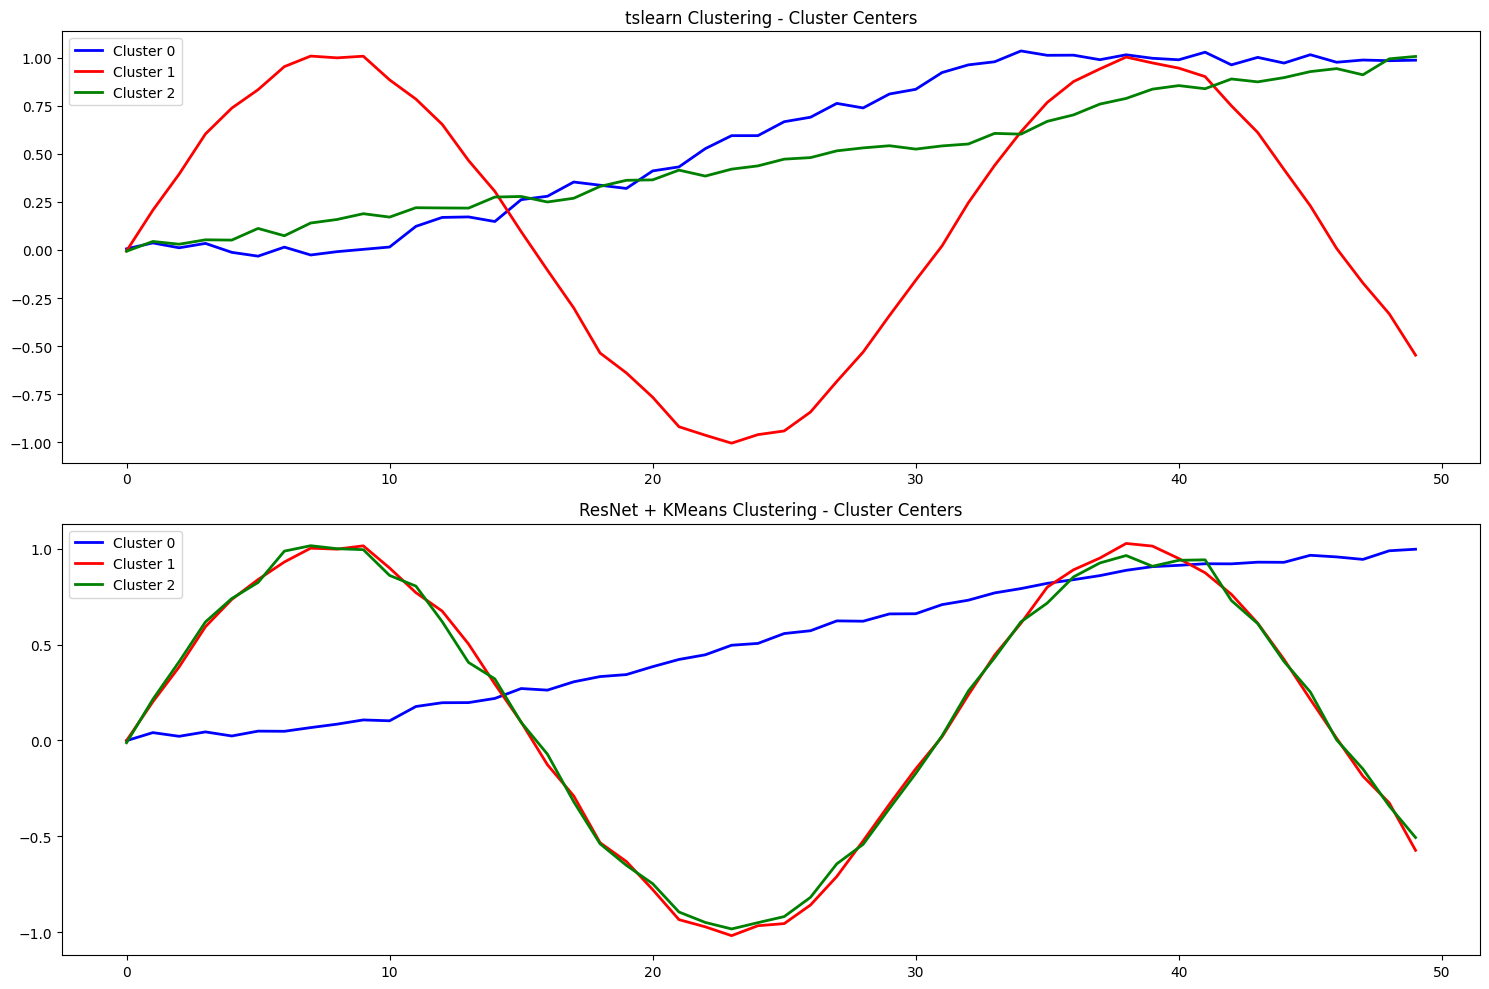


Clustering Performance Comparison:
tslearn Clustering Silhouette Score: 0.618
ResNet Clustering Silhouette Score: 0.487


In [6]:
# Create a comparison plot to visually compare the clustering results
# Create a figure with two subplots: one for tslearn clustering and one for ResNet + KMeans clustering
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Step 1: Plot tslearn clustering results
# Loop through each cluster and plot the mean time series for each cluster
for i in range(n_clusters):
    # Extract time series belonging to the current cluster
    cluster_data = data[tslearn_clusters == i]

    # Plot the average (mean) time series for this cluster with the corresponding color
    axes[0].plot(np.mean(cluster_data, axis=0),
                 c=colors[i],  # Use the color corresponding to this cluster
                 linewidth=2,   # Set the line width to make the cluster center stand out
                 label=f'Cluster {i}')  # Label the cluster center
# Set title and legend for tslearn clustering plot
axes[0].set_title('tslearn Clustering - Cluster Centers')  # Title for the plot
axes[0].legend()  # Show the legend indicating the cluster names

# Step 2: Plot ResNet + KMeans clustering results
# Loop through each cluster and plot the mean time series for each cluster
for i in range(n_clusters):
    # Extract time series belonging to the current cluster
    cluster_data = data[resnet_clusters == i]

    # Plot the average (mean) time series for this cluster with the corresponding color
    axes[1].plot(np.mean(cluster_data, axis=0),
                 c=colors[i],  # Use the color corresponding to this cluster
                 linewidth=2,   # Set the line width to make the cluster center stand out
                 label=f'Cluster {i}')  # Label the cluster center
# Set title and legend for ResNet + KMeans clustering plot
axes[1].set_title('ResNet + KMeans Clustering - Cluster Centers')  # Title for the plot
axes[1].legend()  # Show the legend indicating the cluster names

# Adjust layout to prevent overlapping subplots
plt.tight_layout()

# Display the plots
plt.show()

# Step 3: Print a comparison of the clustering performance using the silhouette scores
# The silhouette score measures how well-separated the clusters are
print("\nClustering Performance Comparison:")
print(f"tslearn Clustering Silhouette Score: {tslearn_score:.3f}")  # Print tslearn silhouette score
print(f"ResNet Clustering Silhouette Score: {resnet_score:.3f}")  # Print ResNet + KMeans silhouette score
